Cluster Analysis of municipalities in the commuter belt around Brussels, Belgium

Version V2 - this is the final version for the course assignment - see report and BruBeltFinalV1 for further background

Data sources: a csv file with geolocation information for every municipality in Belgium, which is then leveraged as a basis for obtaining data from Foursquare on food- and drink-related venues in various municipalities

Note: in the first few code blocks, I import all the libraries I need , based on the New York assignment we studied in the course

In [1]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
import json5 # library to handle JSON files

In [2]:
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

In [3]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

In [4]:
# import k-means from clustering stage
from sklearn.cluster import KMeans

In [5]:
import folium # map rendering library

In [6]:
print('Libraries imported.')

Libraries imported.


In [7]:
# display options so as to view data frames in full
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

Source of data is github user jief - special thanks

In [8]:
url = 'https://raw.githubusercontent.com/jief/zipcode-belgium/master/zipcode-belgium.csv'

In [9]:
xx=pd.read_csv(url, header=None) # read data frame from the designated url

In [10]:
xx.head(10)

,0,1,2,3
0,1000,Bruxelles,4.351697,50.846557
1,1020,Laeken,4.348713,50.883392
2,1030,Schaerbeek,4.373712,50.867604
3,1040,Etterbeek,4.389510,50.836851
4,1050,Ixelles,4.381571,50.822285
5,1060,Saint-Gilles,4.345668,50.826741
6,1070,Anderlecht,4.312340,50.838141
7,1080,Molenbeek-Saint-Jean,4.322778,50.854355
8,1081,Koekelberg,4.325708,50.862263
9,1082,Berchem-Sainte-Agathe,4.292702,50.863984


In [11]:
xx.columns=['Postal','Municipality','Long','Lat']

In [12]:
xx.head(10)

,Postal,Municipality,Long,Lat
0,1000,Bruxelles,4.351697,50.846557
1,1020,Laeken,4.348713,50.883392
2,1030,Schaerbeek,4.373712,50.867604
3,1040,Etterbeek,4.389510,50.836851
4,1050,Ixelles,4.381571,50.822285
5,1060,Saint-Gilles,4.345668,50.826741
6,1070,Anderlecht,4.312340,50.838141
7,1080,Molenbeek-Saint-Jean,4.322778,50.854355
8,1081,Koekelberg,4.325708,50.862263
9,1082,Berchem-Sainte-Agathe,4.292702,50.863984


In [13]:
xx.shape

(2757, 4)

I now define the municipality of Brussels as the centre - because later I will compute distances from that centre

In [14]:
centre=xx[xx['Municipality'].str.contains('Bruxelles')]
centre

,Postal,Municipality,Long,Lat
0,1000,Bruxelles,4.351697,50.846557


I will use the Haversine distance function to compute distances from each municipality to Brussels, in km

In [15]:
# source of code
# https://towardsdatascience.com/heres-how-to-calculate-distance-between-2-geolocations-in-python-93ecab5bbba4

def haverdist(lat1, lon1, lat2, lon2):
   r = 6371
   phi1 = np.radians(lat1)
   phi2 = np.radians(lat2)
   delta_phi = np.radians(lat2 - lat1)
   delta_lambda = np.radians(lon2 - lon1)
   a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2)**2
   res = r * (2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a)))
   return np.round(res, 2)

p1lat=float(centre['Lat'])
p1long=float(centre['Long'])

def haver_df(row):
    p2lat=float(row['Lat'])
    p2long=float(row['Long'])
    dist=haverdist(p1lat,p1long,p2lat,p2long)
    return dist

xx['Dist']=xx.apply (lambda row: haver_df(row), axis=1)

xx.head(10)

,Postal,Municipality,Long,Lat,Dist
0,1000,Bruxelles,4.351697,50.846557,0.00
1,1020,Laeken,4.348713,50.883392,4.10
2,1030,Schaerbeek,4.373712,50.867604,2.80
3,1040,Etterbeek,4.389510,50.836851,2.87
4,1050,Ixelles,4.381571,50.822285,3.42
5,1060,Saint-Gilles,4.345668,50.826741,2.24
6,1070,Anderlecht,4.312340,50.838141,2.92
7,1080,Molenbeek-Saint-Jean,4.322778,50.854355,2.21
8,1081,Koekelberg,4.325708,50.862263,2.53
9,1082,Berchem-Sainte-Agathe,4.292702,50.863984,4.57


My focus is on the 'commuter belt' around Brussels, which I define as being between 7 and 20 km from Brussels

In [16]:
max_dist=20
min_dist=7
region=xx[xx['Dist']<max_dist]
region=region[region['Dist']>min_dist]
region.shape

(114, 5)

In [17]:
region.head(10)

,Postal,Municipality,Long,Lat,Dist
25,1310,La Hulpe,4.479654,50.731505,15.64
41,1330,Rixensart,4.527290,50.713355,19.28
42,1331,Rosières,4.546311,50.737130,18.31
43,1332,Genval,4.497139,50.720745,17.33
87,1380,Ohain,4.450553,50.695114,18.22
99,1410,Waterloo,4.397805,50.717356,14.73
100,1420,Braine-L'alleud,4.354815,50.694094,16.95
110,1440,Braine-Le-Château,4.266669,50.680882,19.37
111,1440,Wauthier-Braine,4.313304,50.680832,18.62
132,1480,Clabecq,4.221413,50.689374,19.73


Now that I have my region of focus, I will get data on venues in this region from Foursquare

Define credentials for Foursquare requests

In [18]:
CLIENT_ID = 'ZO3BBSIQNBQP3WG1YW0X0JUB0GCG0BTCRRBIZLALIWTTQK1X'
CLIENT_SECRET = 'S0GMZOANBJLCXIJMUCK0MPRMYLNNBBEHDVJWS5QLJHBHIL50'
VERSION = '20180605' # Foursquare API version

In [19]:
# as in the course example, define max no of venues to be extracted per request, and define geog. radius of requests
# compared to the NYC example in the course, we're looking at small towns and villages with a relatively small number
# of venues; it's also necessary to scan over a larger radius (1000 instead of 500) around the centre of each location
LIMIT=100
radius_4sq=1000

In [20]:
def getNearbyVenues(names, latitudes, longitudes, rad=radius_4sq):
    
    venues_list=[]
    print("Processing each municipality...")
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            rad, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Municipality', 
                  'Mun Lat', 
                  'Mun Long', 
                  'Venue', 
                  'Venue Lat', 
                  'Venue Long', 
                  'Venue Cat']
    
    return(nearby_venues)

In [22]:
print("Getting venue information by municipality")
venues = getNearbyVenues(names=region['Municipality'],
                                   latitudes=region['Lat'],
                                   longitudes=region['Long']
                                  )
print("Venue information has been obtained!")

Getting venue information by municipality
Processing each municipality...
La Hulpe
Rixensart
Rosières
Genval
Ohain
Waterloo
Braine-L'alleud
Braine-Le-Château
Wauthier-Braine
Clabecq
Tubize
Halle
Buizingen
Lembeek
Hoeilaart
Oudenaken
Sint-Laureins-Berchem
Sint-Pieters-Leeuw
Ruisbroek
Vlezenbeek
Drogenbos
Linkebeek
Rhode-Saint-Genèse
Beersel
Lot
Alsemberg
Dworp
Huizingen
Bogaarden
Pepingen
Elingen
Beert
Bellingen
Sint-Martens-Bodegem
Sint-Ulriks-Kapelle
Itterbeek
Schepdaal
Asse
Bekkerzeel
Kobbegem
Mollem
Relegem
Ternat
Wambeek
Sint-Katherina-Lombeek
Mazenzele
Opwijk
Gaasbeek
Lennik
Sint-Kwintens-Lennik
Sint-Martens-Lennik
Gooik
Kester
Leerbeek
Onze-Lieve-Vrouw-Lombeek
Pamel
Roosdaal
Strijtem
Borchtlombeek
Liedekerke
Wemmel
Brussegem
Merchtem
Affligem
Essene
Hekelgem
Teralfene
Peutie
Vilvoorde
Melsbroek
Perk
Steenokkerzeel
Machelen
Diegem
Londerzeel
Steenhuffel
Grimbergen
Humbeek
Beigem
Strombeek-Bever
Meise
Wolvertem
Kapelle-Op-Den-Bos
Nieuwenrode
Ramsdonk
Kampenhout
Nederokkerzeel
Nosse

In [23]:
print(venues.shape)
venues.head(12)

(3205, 7)


,Municipality,Mun Lat,Mun Long,Venue,Venue Lat,Venue Long,Venue Cat
0,La Hulpe,50.731505,4.479654,Barbavin,50.730077,4.480356,French Restaurant
1,La Hulpe,50.731505,4.479654,Les Tartes de Françoise,50.730594,4.482041,Bakery
2,La Hulpe,50.731505,4.479654,Le 20 Heures Vin,50.730868,4.486052,Wine Bar
3,La Hulpe,50.731505,4.479654,Nanoo's,50.730851,4.485829,French Restaurant
4,La Hulpe,50.731505,4.479654,S'eat,50.727353,4.487566,Snack Place
5,La Hulpe,50.731505,4.479654,"Giot, createur de saveurs",50.730434,4.482144,Gourmet Shop
6,La Hulpe,50.731505,4.479654,Jardin du Sud,50.730507,4.482617,Asian Restaurant
7,La Hulpe,50.731505,4.479654,Le Solitaire,50.730995,4.487079,Cheese Shop
8,La Hulpe,50.731505,4.479654,Chez Clément,50.726785,4.486916,French Restaurant
9,La Hulpe,50.731505,4.479654,SWIFT - Atrium Café,50.734424,4.478509,Café


I will now restrict the dataset to include only those venue types that relate to food and drink

In [24]:
match_str='Food|Drink|Bakery|Gourmet|Wine|Beer|Cheese|Snack|Fish|Meat|Restaurant|Salad|Bistro|Bar|Café|Cafe|Coffee|Pizza|Friterie|Gastropub|Pub|Fruit|Farmers|Cafeteria'
df2=venues[venues['Venue Cat'].str.contains(match_str)].reset_index()

#remove duplicate venues (a few venues are recorded twice, in two neigbouring municipalities)
df2.drop_duplicates(subset='Venue', inplace=True)

# show head
df2.shape

(1084, 8)

In [25]:
df2.tail(10)

,index,Municipality,Mun Lat,Mun Long,Venue,Venue Lat,Venue Long,Venue Cat
1155,3185,Meldert,50.934833,4.133938,cocktailkafaat,50.934437,4.135870,Cocktail Bar
1156,3186,Meldert,50.934833,4.133938,Café Ingrid,50.934005,4.134977,Bar
1157,3187,Meldert,50.934833,4.133938,Zaal bij Ingrid,50.934130,4.134759,Pub
1158,3188,Meldert,50.934833,4.133938,Crabbe,50.935648,4.136949,Bakery
1159,3191,Meldert,50.934833,4.133938,T'vertier,50.932288,4.133955,Bar
1160,3196,Meldert,50.934833,4.133938,De Kruidenier van Affligem,50.932220,4.127800,Gourmet Shop
1161,3197,Meldert,50.934833,4.133938,Café Marina,50.934430,4.126222,Bar
1162,3199,Meldert,50.934833,4.133938,Kantine TK Meldert,50.935826,4.126064,Cafeteria
1163,3202,Meldert,50.934833,4.133938,Business Restaurant TK Meldert,50.936125,4.125910,Restaurant
1164,3203,Meldert,50.934833,4.133938,hotel corthals,50.930073,4.139732,Gluten-free Restaurant


In [26]:
# one hot encoding - same as in the course
onehot = pd.get_dummies(df2[['Venue Cat']], prefix="", prefix_sep="")

# add municipality column back to dataframe
onehot['Municipality'] = df2['Municipality'] 

# move municipality column to the first column
fixed_columns = [onehot.columns[-1]] + list(onehot.columns[:-1])
onehot = onehot[fixed_columns]

onehot.head(10)

,Municipality,African Restaurant,Argentinian Restaurant,Asian Restaurant,Bakery,Bar,Beach Bar,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Bistro,Cafeteria,Café,Cheese Shop,Chinese Restaurant,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Doner Restaurant,Eastern European Restaurant,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fishing Spot,Fishing Store,Food & Drink Shop,Food Service,Food Truck,French Restaurant,Friterie,Fruit & Vegetable Store,Gastropub,German Restaurant,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Health Food Store,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Karaoke Bar,Kebab Restaurant,Korean Restaurant,Lebanese Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Pizza Place,Pub,Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Seafood Restaurant,Slovak Restaurant,Snack Place,Spanish Restaurant,Sports Bar,Sushi Restaurant,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Turkish Restaurant,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop
0,La Hulpe,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,La Hulpe,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,La Hulpe,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,La Hulpe,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,La Hulpe,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
5,La Hulpe,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,La Hulpe,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,La Hulpe,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,La Hulpe,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,La Hulpe,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [27]:
# a little bit more diagnostics as compared to the course material
# one concern I have is municipalities with very small numbers of venues - e.g. very small villages, or missing data
# So, I group-by on totals, not on means - but I will come back to means further down
grouped = onehot.groupby('Municipality').sum().reset_index()

grouped['Total'] = grouped.sum(axis=1, numeric_only=True)

# I now decide to drop all municipalities with less than 5 venues
# Later I will also focus on the 5 most common venue types in the later presentation
grouped=grouped[grouped['Total']>=5]

# Now I will seek to differentiate between costlier venues, typically associated with higher socio-economic status
# such as French Restaurants and Wine Bars, and budget venues such as Fast Food and Pizza places
grouped['Status']=grouped['French Restaurant']+grouped['Cheese Shop']+grouped['Gourmet Shop']+grouped['Wine Bar']+grouped['Gastropub']+grouped['Wine Shop']+grouped['Whisky Bar']
grouped['Budget']=grouped['Snack Place']+grouped['Fast Food Restaurant']+grouped['Pizza Place']+grouped['Sports Bar']+grouped['Cafeteria']
grouped['Neutral']=grouped['Total']-grouped['Status']-grouped['Budget']

# Now I create a simpler dataset which focuses only on the shares of Status, Budget, and Neutral venues
# I do this based on experience using this dataset and based on local knowledge - there are differences
# in the locations around Brussels in terms of how 'upmarket' or 'downmarket' they are
# this is an attempt to capture that - and then feed it into a K-Means approach
# also because, when I tried to feed just the venue data, K-Means didn't yield any clear number of clusters
# except on the basis of total size. I.e. if the total number of venues was not in the dataset, then the Elbow Chart derived
# from iterating K-Means over 1 to 25 clusters gave quite regular downward sloping curves, without any clear 'elbow'

grouped2=grouped.loc[:,'Status':'Neutral'].div(grouped['Total'], axis=0)
grouped2.insert(0, 'Municipality', grouped['Municipality'])

grouped2.reset_index(inplace=True)
grouped2.drop(columns='index',inplace=True)
grouped2.head(10)

# NOTE: for the generation of the results discussed in the report, I ran the code according to two variants
# The first based on the 'grouped' dataframe without the Total, Status, Budget, Neutral columns - but with the full
# data on venues. In the report, I present the 'Elbow Graph' that results from that approach.
# The second variant, which I prefer, is based on the grouped2 dataframe, which keeps only the Status, Budget, Neutral
# columns, as shown in the output below - and without the raw data on venues. That yields a different 'Elbow Graph'
# which I find more convincing
# Note however that I keep the full dataset for the purposes of presenting the most common types of venues
# as that is still an attractive part of the data presentation which I want to keep from the course example



,Municipality,Status,Budget,Neutral
0,Affligem,0.000000,0.250000,0.750000
1,Asse,0.000000,0.000000,1.000000
2,Baardegem,0.000000,0.000000,1.000000
3,Beersel,0.062500,0.062500,0.875000
4,Beigem,0.111111,0.111111,0.777778
5,Bertem,0.111111,0.111111,0.777778
6,Borchtlombeek,0.000000,0.000000,1.000000
7,Braine-L'alleud,0.000000,0.000000,1.000000
8,Braine-Le-Château,0.214286,0.071429,0.714286
9,Buizingen,0.000000,0.111111,0.888889


In [28]:
grouped.drop(columns=['Neutral','Budget','Status','Total'], inplace=True)
grouped.reset_index(inplace=True)
grouped.drop(columns=['index'], inplace=True)
grouped.head(10)

,Municipality,African Restaurant,Argentinian Restaurant,Asian Restaurant,Bakery,Bar,Beach Bar,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Bistro,Cafeteria,Café,Cheese Shop,Chinese Restaurant,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Doner Restaurant,Eastern European Restaurant,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fishing Spot,Fishing Store,Food & Drink Shop,Food Service,Food Truck,French Restaurant,Friterie,Fruit & Vegetable Store,Gastropub,German Restaurant,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Health Food Store,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Karaoke Bar,Kebab Restaurant,Korean Restaurant,Lebanese Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Pizza Place,Pub,Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Seafood Restaurant,Slovak Restaurant,Snack Place,Spanish Restaurant,Sports Bar,Sushi Restaurant,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Turkish Restaurant,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop
0,Affligem,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,Asse,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,Baardegem,0,0,0,0,3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,Beersel,0,1,0,2,3,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,Beigem,0,0,0,0,2,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
5,Bertem,0,0,0,0,4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
6,Borchtlombeek,0,0,0,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,Braine-L'alleud,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,Braine-Le-Château,0,0,1,2,2,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,Buizingen,0,0,0,0,3,0,0,0,1,0,0,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Define function to sort venues in descending order of frequency - I keep the part that follows from the course. The difference in this case is that I'll get absolute counts because I performed groupby on sum() not on mean()

In [37]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [38]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Municipality']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Type'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Type'.format(ind+1))

# create a new dataframe
venues_sorted = pd.DataFrame(columns=columns)
venues_sorted['Municipality'] = grouped['Municipality']

for ind in np.arange(grouped.shape[0]):
    venues_sorted.iloc[ind, 1:] = return_most_common_venues(grouped.iloc[ind, :], num_top_venues)
    
venues_sorted.head(10)

,Municipality,1st Type,2nd Type,3rd Type,4th Type,5th Type
0,Affligem,Bar,Restaurant,Fishing Spot,Sake Bar,Sports Bar
1,Asse,Food Truck,Greek Restaurant,Turkish Restaurant,Bakery,Bar
2,Baardegem,Bar,Food & Drink Shop,Restaurant,Theme Restaurant,Beer Garden
3,Beersel,Bar,Restaurant,Bakery,Italian Restaurant,Belgian Restaurant
4,Beigem,Bar,Wine Shop,Belgian Restaurant,Friterie,Farmers Market
5,Bertem,Bar,Wine Shop,Friterie,Health Food Store,Café
6,Borchtlombeek,Bar,Friterie,Restaurant,Bakery,Food & Drink Shop
7,Braine-L'alleud,Restaurant,Bar,Health Food Store,Food Service,Asian Restaurant
8,Braine-Le-Château,Restaurant,Bakery,Bar,Cheese Shop,Greek Restaurant
9,Buizingen,Bar,Café,Restaurant,Pub,Beer Store


And now the cluster analysis using k-means

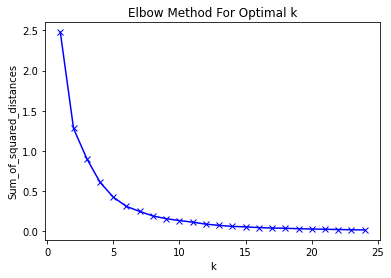

In [39]:
grouped_clustering = grouped2.drop('Municipality', 1)

# run k-means clustering with no of clusters ranging from 1 to 25
# aiming to identify optimal no of clusters
# https://blog.cambridgespark.com/how-to-determine-the-optimal-number-of-clusters-for-k-means-clustering-14f27070048f
    
Sum_of_squared_distances = []
K = range(1,25)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)

import matplotlib.pyplot as plt
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()


In [40]:
# relatively clear elbow at k=5 - gains from further clustering very limited
kclusters=5
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(grouped_clustering)

Create a new dataframe that includes the cluster as well as the top 5 venue types for each neighborhood

In [41]:
# add clustering labels
venues_sorted.insert(1, 'Cluster Labels', kmeans.labels_)
venues_sorted.insert(2,'Status',grouped2['Status'])
venues_sorted.insert(2,'Budget',grouped2['Budget'])
venues_sorted.head(8)

,Municipality,Cluster Labels,Budget,Status,1st Type,2nd Type,3rd Type,4th Type,5th Type
0,Affligem,4,0.250000,0.000000,Bar,Restaurant,Fishing Spot,Sake Bar,Sports Bar
1,Asse,3,0.000000,0.000000,Food Truck,Greek Restaurant,Turkish Restaurant,Bakery,Bar
2,Baardegem,3,0.000000,0.000000,Bar,Food & Drink Shop,Restaurant,Theme Restaurant,Beer Garden
3,Beersel,1,0.062500,0.062500,Bar,Restaurant,Bakery,Italian Restaurant,Belgian Restaurant
4,Beigem,2,0.111111,0.111111,Bar,Wine Shop,Belgian Restaurant,Friterie,Farmers Market
5,Bertem,2,0.111111,0.111111,Bar,Wine Shop,Friterie,Health Food Store,Café
6,Borchtlombeek,3,0.000000,0.000000,Bar,Friterie,Restaurant,Bakery,Food & Drink Shop
7,Braine-L'alleud,3,0.000000,0.000000,Restaurant,Bar,Health Food Store,Food Service,Asian Restaurant


In [42]:
final_df = region

# merge
final_df = final_df.join(venues_sorted.set_index('Municipality'), on='Municipality')

# get rid of rows (municipalities) for which data is not available (in case this occurs)
final_df.dropna(axis=0,inplace=True)

final_df.reset_index(inplace=True)
final_df.drop(columns='index', inplace=True)

final_df.head(10)

,Postal,Municipality,Long,Lat,Dist,Cluster Labels,Budget,Status,1st Type,2nd Type,3rd Type,4th Type,5th Type
0,1310,La Hulpe,4.479654,50.731505,15.64,0.0,0.137931,0.275862,French Restaurant,Bistro,Restaurant,Bakery,Fast Food Restaurant
1,1330,Rixensart,4.527290,50.713355,19.28,4.0,0.285714,0.142857,Bakery,Pizza Place,French Restaurant,Thai Restaurant,Farmers Market
2,1410,Waterloo,4.397805,50.717356,14.73,2.0,0.105263,0.210526,French Restaurant,Bar,Restaurant,Bakery,Italian Restaurant
3,1420,Braine-L'alleud,4.354815,50.694094,16.95,3.0,0.000000,0.000000,Restaurant,Bar,Health Food Store,Food Service,Asian Restaurant
4,1440,Braine-Le-Château,4.266669,50.680882,19.37,2.0,0.071429,0.214286,Restaurant,Bakery,Bar,Cheese Shop,Greek Restaurant
5,1480,Clabecq,4.221413,50.689374,19.73,1.0,0.200000,0.000000,Bakery,Pizza Place,Friterie,Italian Restaurant,Fishing Spot
6,1480,Tubize,4.204696,50.693020,19.96,1.0,0.153846,0.000000,Italian Restaurant,Friterie,Pizza Place,Asian Restaurant,Greek Restaurant
7,1500,Halle,4.237435,50.736052,14.68,3.0,0.042553,0.021277,Bar,Restaurant,Italian Restaurant,Coffee Shop,Friterie
8,1501,Buizingen,4.260508,50.737934,13.67,1.0,0.111111,0.000000,Bar,Café,Restaurant,Pub,Beer Store
9,1502,Lembeek,4.214343,50.709295,18.06,3.0,0.000000,0.090909,Bar,Friterie,Gastropub,Belgian Restaurant,Beer Garden


Create map with clusters - based on what we saw in the course, but I had into the labels the scores for the 'Budget' and 'Status' categories that I defined earlier

In [49]:
# create map with clusters - centred on the central point (Brussels) that I chose earlier

c_lat=centre['Lat']
c_long=centre['Long']

map_clusters = folium.Map(location=[c_lat, c_long], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, stat, bud in zip(final_df['Lat'], final_df['Long'], final_df['Municipality'], final_df['Cluster Labels'], final_df['Status'], final_df['Budget']):
    label = folium.Popup(str(poi) + ' -Cluster: ' + str(round(cluster,0)) + ' -Status: ' + str(round(stat,3)) + ' -Budget: ' + str(round(bud,3)), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters.save("belmap2.html")
print("belmap2 saved")
map_clusters

belmap2 saved
